# Assignment 6:Machine Learning

## Part 1: Data Preparation

#### Disclaimer: The data and some preparation code are taken from the UCI repository

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import torch
from torch.utils.data import Dataset, DataLoader
%matplotlib inline

In [2]:
columns = ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status',
           'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss',
           'hours-per-week', 'native-country', 'income']

train = pd.read_csv('adult/adult.data', header=None, names=columns, skipinitialspace=True, na_values='?')
test = pd.read_csv('adult/adult.test', header=None, names=columns, skipinitialspace=True, na_values='?', skiprows=1)
full_data = pd.concat([train, test])
full_data.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [3]:
full_data = full_data.drop_duplicates()
full_data = full_data.dropna()
full_data.info()


<class 'pandas.core.frame.DataFrame'>
Index: 45194 entries, 0 to 16280
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             45194 non-null  int64 
 1   workclass       45194 non-null  object
 2   fnlwgt          45194 non-null  int64 
 3   education       45194 non-null  object
 4   education-num   45194 non-null  int64 
 5   marital-status  45194 non-null  object
 6   occupation      45194 non-null  object
 7   relationship    45194 non-null  object
 8   race            45194 non-null  object
 9   sex             45194 non-null  object
 10  capital-gain    45194 non-null  int64 
 11  capital-loss    45194 non-null  int64 
 12  hours-per-week  45194 non-null  int64 
 13  native-country  45194 non-null  object
 14  income          45194 non-null  object
dtypes: int64(6), object(9)
memory usage: 5.5+ MB


In [4]:
# Transform the target variable into 1s and 0s

full_data['income'] = full_data['income'].map({
    '>50K': 1,
    '>50K.': 1,
    '<=50K': 0,
    '<=50K.': 0})
full_data.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,0
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,0
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,0
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,0
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,0


In [5]:
full_data.info()
df = full_data

<class 'pandas.core.frame.DataFrame'>
Index: 45194 entries, 0 to 16280
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             45194 non-null  int64 
 1   workclass       45194 non-null  object
 2   fnlwgt          45194 non-null  int64 
 3   education       45194 non-null  object
 4   education-num   45194 non-null  int64 
 5   marital-status  45194 non-null  object
 6   occupation      45194 non-null  object
 7   relationship    45194 non-null  object
 8   race            45194 non-null  object
 9   sex             45194 non-null  object
 10  capital-gain    45194 non-null  int64 
 11  capital-loss    45194 non-null  int64 
 12  hours-per-week  45194 non-null  int64 
 13  native-country  45194 non-null  object
 14  income          45194 non-null  int64 
dtypes: int64(7), object(8)
memory usage: 5.5+ MB


In [6]:
TARGET = 'income'
features = df.drop(columns=[TARGET])
target = df[TARGET]

In [7]:
# Identify numerical and categorical columns
numerical_cols = ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
categorical_cols = ['workclass', 'education', 'marital-status', 'occupation', 
                    'relationship', 'race', 'sex', 'native-country']

# Numerical pipeline: Standard Scaling
numerical_pipeline = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Categorical pipeline: One-Hot Encoding
categorical_pipeline = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine pipelines using ColumnTransformer
preprocessor = ColumnTransformer(transformers=[
    ('num', numerical_pipeline, numerical_cols),
    ('cat', categorical_pipeline, categorical_cols)
])


In [8]:
# Fit and transform the features
X = preprocessor.fit_transform(features)

# Convert target to numpy array
y = target.values

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42,
    stratify=y
)
X_train = X_train.todense()
X_test = X_test.todense()

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)


In [9]:
# Define custom Dataset
class IncomeDataset(Dataset):
    def __init__(self, features, labels):
        self.X = features
        self.y = labels
    
    def __len__(self):
        return self.X.shape[0]
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Create Dataset objects
train_dataset = IncomeDataset(X_train_tensor, y_train_tensor)
test_dataset = IncomeDataset(X_test_tensor, y_test_tensor)

# Create DataLoader objects
batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Verify DataLoader
for batch_features, batch_labels in train_loader:
    print(f'Features batch shape: {batch_features.size()}')
    print(f'Labels batch shape: {batch_labels.size()}')
    break

Features batch shape: torch.Size([64, 104])
Labels batch shape: torch.Size([64, 1])


## Model Implementations

Implementation from scratch using PyTorch.
Note that if you want to replicate this training, you may need to utilize a GPU device or it will take longer than an hour on CPU.

In [10]:
import torch
import torch.nn as nn

class LogisticRegressionModel(nn.Module):
    def __init__(self, input_dim):
        super(LogisticRegressionModel, self).__init__()
        self.linear = nn.Linear(input_dim, 1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        out = self.linear(x)
        out = self.sigmoid(out)
        return out

In [11]:
class SimpleFeedforwardNN(nn.Module):
    def __init__(self, input_dim, hidden_dim=64):
        super(SimpleFeedforwardNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, 1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.sigmoid(out)
        return out

In [12]:
class DeepNeuralNetwork(nn.Module):
    def __init__(self, input_dim, hidden_dims=[128, 64, 32], dropout_prob=0.5):
        super(DeepNeuralNetwork, self).__init__()
        layers = []
        previous_dim = input_dim
        
        for hidden_dim in hidden_dims:
            layers.append(nn.Linear(previous_dim, hidden_dim))
            layers.append(nn.BatchNorm1d(hidden_dim))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout_prob))
            previous_dim = hidden_dim
        
        layers.append(nn.Linear(previous_dim, 1))
        layers.append(nn.Sigmoid())
        
        self.network = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.network(x)

In [13]:
# Assuming X_train has been preprocessed and converted to a NumPy array or PyTorch tensor
input_dim = X_train_tensor.shape[1]

# Instantiate Logistic Regression Model
logistic_model = LogisticRegressionModel(input_dim)

# Instantiate Simple Feedforward Neural Network
simple_mlp = SimpleFeedforwardNN(input_dim, hidden_dim=64)

# Instantiate Deep Neural Network
deep_nn = DeepNeuralNetwork(input_dim, hidden_dims=[128, 64, 32], dropout_prob=0.5)

# Print model architectures
print("Logistic Regression Model:\n", logistic_model)
print("\nSimple Feedforward Neural Network:\n", simple_mlp)
print("\nDeep Neural Network:\n", deep_nn)

Logistic Regression Model:
 LogisticRegressionModel(
  (linear): Linear(in_features=104, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

Simple Feedforward Neural Network:
 SimpleFeedforwardNN(
  (fc1): Linear(in_features=104, out_features=64, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=64, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

Deep Neural Network:
 DeepNeuralNetwork(
  (network): Sequential(
    (0): Linear(in_features=104, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.5, inplace=False)
    (8): Linear(in_features=64, out_features=32, bias=True)
    (9): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): R

## 3. Training and Tuning

In [14]:
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, f1_score
from itertools import product
import copy

In [15]:
# Hyperparameter grids for each model

# Logistic Regression Hyperparameters
logistic_hyperparams = {
    'learning_rate': [0.01, 0.001],
}

# Simple Feedforward NN Hyperparameters
simple_mlp_hyperparams = {
    'learning_rate': [0.01, 0.001],
    'hidden_dim': [64, 128],
}

# Deep Neural Network Hyperparameters
deep_nn_hyperparams = {
    'learning_rate': [0.001, 0.0001],
    'hidden_dims': [[128, 64, 32], [256, 128, 64]],
    'dropout_prob': [0.3, 0.5],
}

In [16]:
def train_model(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    for batch_features, batch_labels in dataloader:
        batch_features = batch_features.to(device)
        batch_labels = batch_labels.to(device)
        
        # Zero the gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(batch_features)
        loss = criterion(outputs, batch_labels)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * batch_features.size(0)
    
    epoch_loss = running_loss / len(dataloader.dataset)
    return epoch_loss

In [17]:
def evaluate_model(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for batch_features, batch_labels in dataloader:
            batch_features = batch_features.to(device)
            batch_labels = batch_labels.to(device)
            
            outputs = model(batch_features)
            preds = (outputs >= 0.5).float()
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(batch_labels.cpu().numpy())
    
    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    return accuracy, f1

In [18]:
def cross_validate(model_class, hyperparams, X_train, y_train, k_folds=5, num_epochs=10, batch_size=64, device='cpu'):
    kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)
    
    accuracies = []
    f1_scores = []
    
    for fold, (train_index, val_index) in enumerate(kf.split(X_train)):
        print(f'Fold {fold + 1}/{k_folds}')
        
        # Split the data
        X_tr, X_val = X_train[train_index], X_train[val_index]
        y_tr, y_val = y_train[train_index], y_train[val_index]
        
        # Convert to tensors
        X_tr_tensor = torch.tensor(X_tr, dtype=torch.float32).to(device)
        y_tr_tensor = torch.tensor(y_tr, dtype=torch.float32).unsqueeze(1).to(device)
        
        X_val_tensor = torch.tensor(X_val, dtype=torch.float32).to(device)
        y_val_tensor = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1).to(device)
        
        # Create DataLoaders
        train_dataset = torch.utils.data.TensorDataset(X_tr_tensor, y_tr_tensor)
        val_dataset = torch.utils.data.TensorDataset(X_val_tensor, y_val_tensor)
        
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
        
        # Initialize the model
        if model_class == LogisticRegressionModel:
            model = model_class(input_dim=X_train.shape[1]).to(device)
        elif model_class == SimpleFeedforwardNN:
            model = model_class(input_dim=X_train.shape[1], hidden_dim=hyperparams['hidden_dim']).to(device)
        elif model_class == DeepNeuralNetwork:
            model = model_class(input_dim=X_train.shape[1],
                                hidden_dims=hyperparams['hidden_dims'],
                                dropout_prob=hyperparams['dropout_prob']).to(device)
        else:
            raise ValueError("Unsupported model class")
        
        # Define loss and optimizer
        criterion = nn.BCELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=hyperparams['learning_rate'])
        
        # Training loop
        for epoch in range(num_epochs):
            train_loss = train_model(model, train_loader, criterion, optimizer, device)
            # Optional: Print progress
            # print(f'Epoch {epoch+1}/{num_epochs}, Loss: {train_loss:.4f}')
        
        # Evaluation
        accuracy, f1 = evaluate_model(model, val_loader, device)
        print(f'Validation Accuracy: {accuracy:.4f}, F1-Score: {f1:.4f}\n')
        accuracies.append(accuracy)
        f1_scores.append(f1)
    
    avg_accuracy = np.mean(accuracies)
    avg_f1 = np.mean(f1_scores)
    print(f'Average Accuracy: {avg_accuracy:.4f}, Average F1-Score: {avg_f1:.4f}\n')
    
    return avg_accuracy, avg_f1

In [23]:
# Define device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Convert training data to numpy arrays for indexing
X_train_np = X_train_tensor.cpu().numpy()
y_train_np = y_train_tensor.cpu().numpy().flatten()


Using device: cpu


In [29]:

# To store the best hyperparameters and scores
model_results = {
    'LogisticRegressionModel': {'best_params': None, 'best_score': 0},
    'SimpleFeedforwardNN': {'best_params': None, 'best_score': 0},
    'DeepNeuralNetwork': {'best_params': None, 'best_score': 0},
}

# 1. Logistic Regression Model
print("Tuning Logistic Regression Model...\n")
best_f1 = 0
best_params = None

for lr in logistic_hyperparams['learning_rate']:
    hyperparams = {'learning_rate': lr}
    print(f'Evaluating with hyperparameters: {hyperparams}')
    avg_acc, avg_f1 = cross_validate(
        model_class=LogisticRegressionModel,
        hyperparams=hyperparams,
        X_train=X_train_np,
        y_train=y_train_np,
        k_folds=5,
        num_epochs=20,  # Increase epochs for better convergence
        batch_size=64,
        device=device
    )
    if avg_f1 > best_f1:
        best_f1 = avg_f1
        best_params = hyperparams

print(f'Best hyperparameters for Logistic Regression: {best_params}, F1-Score: {best_f1:.4f}\n')
model_results['LogisticRegressionModel']['best_params'] = best_params
model_results['LogisticRegressionModel']['best_score'] = best_f1

# 2. Simple Feedforward Neural Network
print("Tuning Simple Feedforward Neural Network...\n")
best_f1 = 0
best_params = None

for lr, hidden_dim in product(simple_mlp_hyperparams['learning_rate'], simple_mlp_hyperparams['hidden_dim']):
    hyperparams = {'learning_rate': lr, 'hidden_dim': hidden_dim}
    print(f'Evaluating with hyperparameters: {hyperparams}')
    avg_acc, avg_f1 = cross_validate(
        model_class=SimpleFeedforwardNN,
        hyperparams=hyperparams,
        X_train=X_train_np,
        y_train=y_train_np,
        k_folds=5,
        num_epochs=20,
        batch_size=64,
        device=device
    )
    if avg_f1 > best_f1:
        best_f1 = avg_f1
        best_params = hyperparams

print(f'Best hyperparameters for SimpleFeedforwardNN: {best_params}, F1-Score: {best_f1:.4f}\n')
model_results['SimpleFeedforwardNN']['best_params'] = best_params
model_results['SimpleFeedforwardNN']['best_score'] = best_f1

# 3. Deep Neural Network
print("Tuning Deep Neural Network...\n")
best_f1 = 0
best_params = None

for lr, hidden_dims, dropout_prob in product(deep_nn_hyperparams['learning_rate'],
                                            deep_nn_hyperparams['hidden_dims'],
                                            deep_nn_hyperparams['dropout_prob']):
    hyperparams = {'learning_rate': lr, 'hidden_dims': hidden_dims, 'dropout_prob': dropout_prob}
    print(f'Evaluating with hyperparameters: {hyperparams}')
    avg_acc, avg_f1 = cross_validate(
        model_class=DeepNeuralNetwork,
        hyperparams=hyperparams,
        X_train=X_train_np,
        y_train=y_train_np,
        k_folds=5,
        num_epochs=30,  # More epochs for deeper networks
        batch_size=64,
        device=device
    )
    if avg_f1 > best_f1:
        best_f1 = avg_f1
        best_params = hyperparams

print(f'Best hyperparameters for DeepNeuralNetwork: {best_params}, F1-Score: {best_f1:.4f}\n')
model_results['DeepNeuralNetwork']['best_params'] = best_params
model_results['DeepNeuralNetwork']['best_score'] = best_f1

Using device: cpu
Tuning Logistic Regression Model...

Evaluating with hyperparameters: {'learning_rate': 0.01}
Fold 1/5


/kuacc/users/mkizil19/hpc_run/flaxenv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Validation Accuracy: 0.8452, F1-Score: 0.6616

Fold 2/5
Validation Accuracy: 0.8486, F1-Score: 0.6899

Fold 3/5
Validation Accuracy: 0.8476, F1-Score: 0.6708

Fold 4/5
Validation Accuracy: 0.8436, F1-Score: 0.6639

Fold 5/5
Validation Accuracy: 0.8542, F1-Score: 0.6751

Average Accuracy: 0.8478, Average F1-Score: 0.6723

Evaluating with hyperparameters: {'learning_rate': 0.001}
Fold 1/5
Validation Accuracy: 0.8462, F1-Score: 0.6564

Fold 2/5
Validation Accuracy: 0.8511, F1-Score: 0.6837

Fold 3/5
Validation Accuracy: 0.8506, F1-Score: 0.6687

Fold 4/5
Validation Accuracy: 0.8417, F1-Score: 0.6550

Fold 5/5
Validation Accuracy: 0.8558, F1-Score: 0.6696

Average Accuracy: 0.8491, Average F1-Score: 0.6667

Best hyperparameters for Logistic Regression: {'learning_rate': 0.01}, F1-Score: 0.6723

Tuning Simple Feedforward Neural Network...

Evaluating with hyperparameters: {'learning_rate': 0.01, 'hidden_dim': 64}
Fold 1/5
Validation Accuracy: 0.8441, F1-Score: 0.6529

Fold 2/5
Validation Ac

In [21]:
model_results = {
    'LogisticRegressionModel': {'best_params': None, 'best_score': 0},
    'SimpleFeedforwardNN': {'best_params': None, 'best_score': 0},
    'DeepNeuralNetwork': {'best_params': None, 'best_score': 0},
}

model_results['DeepNeuralNetwork']['best_params'] = {'learning_rate': 0.0001, 'hidden_dims': [256, 128, 64], 'dropout_prob': 0.3}
model_results['SimpleFeedforwardNN']['best_params'] = {'learning_rate': 0.001, 'hidden_dim': 64}
model_results['LogisticRegressionModel']['best_params'] = {'learning_rate': 0.01}

In [24]:
# Function to train model on full training data
def train_full_model(model, dataloader, criterion, optimizer, device, num_epochs=20):
    model.train()
    for epoch in range(num_epochs):
        train_loss = train_model(model, dataloader, criterion, optimizer, device)
        # Optional: Print progress
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {train_loss:.4f}')
    return model

# Dictionary to store the best models
best_models = {}

# 1. Logistic Regression Model
print("Training best Logistic Regression Model on full training data...\n")
best_lr_params = model_results['LogisticRegressionModel']['best_params']
logistic_model = LogisticRegressionModel(input_dim=X_train_np.shape[1]).to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(logistic_model.parameters(), lr=best_lr_params['learning_rate'])

train_full_model(
    model=logistic_model,
    dataloader=train_loader,  # Reuse train_loader or create a new one
    criterion=criterion,
    optimizer=optimizer,
    device=device,
    num_epochs=20
)

best_models['LogisticRegressionModel'] = logistic_model

# 2. Simple Feedforward Neural Network
print("Training best Simple Feedforward Neural Network on full training data...\n")
best_simple_params = model_results['SimpleFeedforwardNN']['best_params']
simple_mlp = SimpleFeedforwardNN(input_dim=X_train_np.shape[1], hidden_dim=best_simple_params['hidden_dim']).to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(simple_mlp.parameters(), lr=best_simple_params['learning_rate'])

train_full_model(
    model=simple_mlp,
    dataloader=train_loader,
    criterion=criterion,
    optimizer=optimizer,
    device=device,
    num_epochs=20
)

best_models['SimpleFeedforwardNN'] = simple_mlp

# 3. Deep Neural Network
print("Training best Deep Neural Network on full training data...\n")
best_deep_params = model_results['DeepNeuralNetwork']['best_params']
deep_nn = DeepNeuralNetwork(
    input_dim=X_train_np.shape[1],
    hidden_dims=best_deep_params['hidden_dims'],
    dropout_prob=best_deep_params['dropout_prob']
).to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(deep_nn.parameters(), lr=best_deep_params['learning_rate'])

train_full_model(
    model=deep_nn,
    dataloader=train_loader,
    criterion=criterion,
    optimizer=optimizer,
    device=device,
    num_epochs=30
)

best_models['DeepNeuralNetwork'] = deep_nn

Training best Logistic Regression Model on full training data...



/kuacc/users/mkizil19/hpc_run/flaxenv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Epoch 1/20, Loss: 0.3480
Epoch 2/20, Loss: 0.3269
Epoch 3/20, Loss: 0.3260
Epoch 4/20, Loss: 0.3258
Epoch 5/20, Loss: 0.3257
Epoch 6/20, Loss: 0.3256
Epoch 7/20, Loss: 0.3250
Epoch 8/20, Loss: 0.3253
Epoch 9/20, Loss: 0.3258
Epoch 10/20, Loss: 0.3258
Epoch 11/20, Loss: 0.3254
Epoch 12/20, Loss: 0.3257
Epoch 13/20, Loss: 0.3255
Epoch 14/20, Loss: 0.3252
Epoch 15/20, Loss: 0.3252
Epoch 16/20, Loss: 0.3254
Epoch 17/20, Loss: 0.3259
Epoch 18/20, Loss: 0.3257
Epoch 19/20, Loss: 0.3257
Epoch 20/20, Loss: 0.3252
Training best Simple Feedforward Neural Network on full training data...

Epoch 1/20, Loss: 0.3573
Epoch 2/20, Loss: 0.3168
Epoch 3/20, Loss: 0.3126
Epoch 4/20, Loss: 0.3106
Epoch 5/20, Loss: 0.3086
Epoch 6/20, Loss: 0.3071
Epoch 7/20, Loss: 0.3055
Epoch 8/20, Loss: 0.3047
Epoch 9/20, Loss: 0.3028
Epoch 10/20, Loss: 0.3013
Epoch 11/20, Loss: 0.3005
Epoch 12/20, Loss: 0.2990
Epoch 13/20, Loss: 0.2982
Epoch 14/20, Loss: 0.2995
Epoch 15/20, Loss: 0.2992
Epoch 16/20, Loss: 0.2981
Epoch 17

In [25]:
# Convert test data to tensors
X_test_tensor_device = X_test_tensor.to(device)
y_test_tensor_device = y_test_tensor.to(device)

# Create DataLoader for test set
test_dataset_full = torch.utils.data.TensorDataset(X_test_tensor_device, y_test_tensor_device)
test_loader_full = DataLoader(test_dataset_full, batch_size=64, shuffle=False)

# Dictionary to store evaluation metrics
evaluation_results = {}

for model_name, model in best_models.items():
    print(f'Evaluating {model_name} on test set...')
    accuracy, f1 = evaluate_model(model, test_loader_full, device)
    print(f'Test Accuracy: {accuracy:.4f}, Test F1-Score: {f1:.4f}\n')
    evaluation_results[model_name] = {'accuracy': accuracy, 'f1_score': f1}

Evaluating LogisticRegressionModel on test set...
Test Accuracy: 0.8458, Test F1-Score: 0.6643

Evaluating SimpleFeedforwardNN on test set...
Test Accuracy: 0.8529, Test F1-Score: 0.6727

Evaluating DeepNeuralNetwork on test set...
Test Accuracy: 0.8541, Test F1-Score: 0.6700



In [26]:
# Display the evaluation results
print("Model Evaluation Results on Test Set:")
for model_name, metrics in evaluation_results.items():
    print(f"{model_name}:")
    print(f"  Accuracy: {metrics['accuracy']:.4f}")
    print(f"  F1-Score: {metrics['f1_score']:.4f}\n")

Model Evaluation Results on Test Set:
LogisticRegressionModel:
  Accuracy: 0.8458
  F1-Score: 0.6643

SimpleFeedforwardNN:
  Accuracy: 0.8529
  F1-Score: 0.6727

DeepNeuralNetwork:
  Accuracy: 0.8541
  F1-Score: 0.6700



### I realized we need to handle this imbalance for a better training

In [27]:
class_counts = df['income'].value_counts()
print("Class Distribution:")
print(class_counts)

Class Distribution:
income
0    33988
1    11206
Name: count, dtype: int64


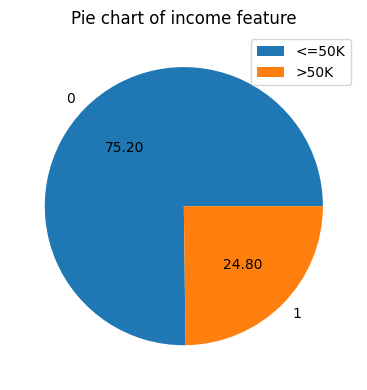

In [7]:
plt.figure(figsize=(6, 4))
plt.pie(x=full_data['income'].value_counts().values, labels=full_data['income'].value_counts().index, autopct='%.2f')
plt.title('Pie chart of income feature')
plt.tight_layout()
plt.legend(['<=50K', '>50K'])
plt.show()

In [13]:
#full_data = full_data.drop('education', axis=1)
#full_data = pd.get_dummies(full_data, columns=['workclass', 'marital-status', 'occupation', 'relationship', 'race', 'sex'], drop_first=True)
full_data.head()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,native-country,income,workclass_Local-gov,workclass_Private,...,relationship_Not-in-family,relationship_Other-relative,relationship_Own-child,relationship_Unmarried,relationship_Wife,race_Asian-Pac-Islander,race_Black,race_Other,race_White,sex_Male
0,39,77516,13,2174,0,40,United-States,0,False,False,...,True,False,False,False,False,False,False,False,True,True
1,50,83311,13,0,0,13,United-States,0,False,False,...,False,False,False,False,False,False,False,False,True,True
2,38,215646,9,0,0,40,United-States,0,False,True,...,True,False,False,False,False,False,False,False,True,True
3,53,234721,7,0,0,40,United-States,0,False,True,...,False,False,False,False,False,False,True,False,False,True
4,28,338409,13,0,0,40,Cuba,0,False,True,...,False,False,False,False,True,False,True,False,False,False


In [14]:
full_data = full_data.drop('native-country', axis=1)


In [15]:
X = full_data.drop('income', axis=1)
y = full_data['income']

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

print(f"Original dataset shape: {X.shape}, {y.shape}")
print(f"Resampled dataset shape: {X_resampled.shape}, {y_resampled.shape}")

Original dataset shape: (45194, 41), (45194,)
Resampled dataset shape: (67976, 41), (67976,)


In [17]:
full_data = pd.concat([X_resampled, y_resampled], axis=1)
full_data.head()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,workclass_Local-gov,workclass_Private,workclass_Self-emp-inc,workclass_Self-emp-not-inc,...,relationship_Other-relative,relationship_Own-child,relationship_Unmarried,relationship_Wife,race_Asian-Pac-Islander,race_Black,race_Other,race_White,sex_Male,income
0,39,77516,13,2174,0,40,False,False,False,False,...,False,False,False,False,False,False,False,True,True,0
1,50,83311,13,0,0,13,False,False,False,True,...,False,False,False,False,False,False,False,True,True,0
2,38,215646,9,0,0,40,False,True,False,False,...,False,False,False,False,False,False,False,True,True,0
3,53,234721,7,0,0,40,False,True,False,False,...,False,False,False,False,False,True,False,False,True,0
4,28,338409,13,0,0,40,False,True,False,False,...,False,False,False,True,False,True,False,False,False,0


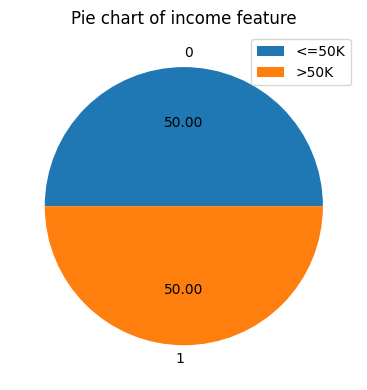

In [18]:
plt.figure(figsize=(6, 4))
plt.pie(x=full_data['income'].value_counts().values, labels=full_data['income'].value_counts().index, autopct='%.2f')
plt.title('Pie chart of income feature')
plt.tight_layout()
plt.legend(['<=50K', '>50K'])
plt.show()

In [20]:
train, test = train_test_split(full_data, random_state=42, test_size=0.2, shuffle=True)
print('Train shape: ', train.shape)
print('Test shape: ', test.shape)

Train shape:  (54380, 42)
Test shape:  (13596, 42)


In [22]:
X_train = train.drop(['income'], axis=1)
y_train = train['income']

X_test = test.drop(['income'], axis=1)
y_test = test['income']

In [23]:
from sklearn.neural_network import MLPClassifier

# Initialize and train the MLP model
mlp_model = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=300, random_state=42)
mlp_model.fit(X_train, y_train)

# Make predictions and evaluate
y_pred_mlp = mlp_model.predict(X_test)

In [24]:
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_mlp))

print("\nClassification Report:")
print(classification_report(y_test, y_pred_mlp))

print("\nAccuracy Score:", accuracy_score(y_test, y_pred_mlp))

Confusion Matrix:
[[6522  246]
 [3612 3216]]

Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.96      0.77      6768
           1       0.93      0.47      0.63      6828

    accuracy                           0.72     13596
   macro avg       0.79      0.72      0.70     13596
weighted avg       0.79      0.72      0.70     13596


Accuracy Score: 0.7162400706090026


In [25]:
from sklearn.tree import DecisionTreeClassifier

# Initialize and train the Decision Tree model
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)

# Make predictions and evaluate
y_pred_dt = dt_model.predict(X_test)

In [26]:
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_dt))

print("\nClassification Report:")
print(classification_report(y_test, y_pred_dt))

print("\nAccuracy Score:", accuracy_score(y_test, y_pred_dt))

Confusion Matrix:
[[5748 1020]
 [ 928 5900]]

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.85      0.86      6768
           1       0.85      0.86      0.86      6828

    accuracy                           0.86     13596
   macro avg       0.86      0.86      0.86     13596
weighted avg       0.86      0.86      0.86     13596


Accuracy Score: 0.8567225654604296
